<a href="https://colab.research.google.com/github/jdtoscano94/Learning-PINNs-in-Pytorch-Physics-Informed-Machine-Learning/blob/main/2_SimpleODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cuda


# Tunning Parameters

In [2]:
steps=20000
lr=1e-3
layers = np.array([1,50,50,50,50,50,1]) #5 hidden layers
min=-1
max=1
total_points=101
#Nu: Number of training points (2 as we onlt have 2 boundaries), # Nf: Number of collocation points (Evaluate PDE)
Nu=2
Nf=total_points;
global k 
k= 100;

## Functions

In [3]:
def f_BC(x): # This function satisfies the boundry conditions. The same as the real one (To ease the data generation), but we may not have it.
  return torch.tanh(k*x)
def PDE(x): # The PDE equation. We use it to get the residual in the Neurl Network.
  return -k*(torch.tanh(k*x)**2 - 1)


## Neural Network

In [4]:

class FCN(nn.Module):
    ##Neural Network
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    'Loss Functions'
    #Loss BC
    def lossBC(self,x_BC):
      loss_BC=self.loss_function(self.forward(x_BC),f_BC(x_BC))
      return loss_BC
    #Loss PDE
    def lossPDE(self,x_PDE):
      g=x_PDE.clone()
      g.requires_grad=True #Enable differentiation
      f=self.forward(g)
      f_x=autograd.grad(f,g,torch.ones([x_PDE.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0]
      loss_PDE=self.loss_function(f_x,PDE(g))
      return loss_PDE
      
    def loss(self,x_BC,x_PDE):
      loss_bc=self.lossBC(x_BC)
      loss_pde=self.lossPDE(x_PDE)
      return loss_bc+loss_pde

    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.lossNN(x_train, y_train)
        
        loss.backward()
                
        self.iter += 1
        
        if self.iter % 100 == 0:
        
            print(loss)

        return loss   

# Generate data

In [5]:
# get the analytical solution over the full domain
x = torch.linspace(min,max,total_points).view(-1,1) #prepare to NN
y = f_BC(x)
print(x.shape, y.shape)


torch.Size([101, 1]) torch.Size([101, 1])


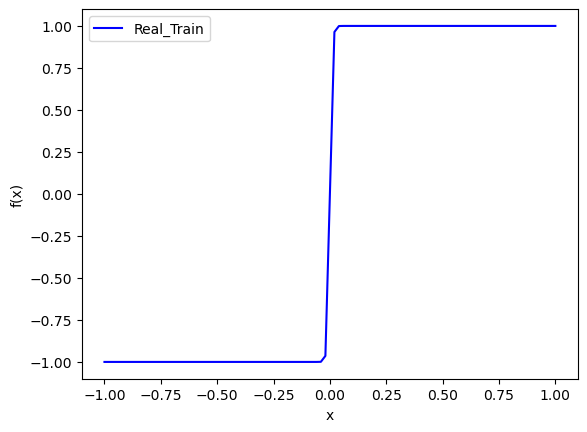

In [6]:
fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(),y.detach().numpy(),color='blue',label='Real_Train')
#ax1.plot(x_train.detach().numpy(),yh.detach().numpy(),color='red',label='Pred_Train')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

In [7]:
#def get_training_data(x):
#Nu: Number of training point, # Nf: Number of colloction points
# Set Boundary conditions:
BC_1=x[0,:]
BC_2=x[-1,:]
# Total Training points BC1+BC2
all_train=torch.vstack([BC_1,BC_2])
#Select Nu points
# idx = np.random.choice(all_train.shape[0], Nu, replace=False) 
x_BC=all_train[:]
#Select Nf points
# Latin Hypercube sampling for collocation points 
# x_PDE = BC_1 + (BC_2-BC_1)*lhs(1,Nf)
x_PDE = x

In [8]:
x.shape

torch.Size([101, 1])

In [9]:
x_PDE.shape

torch.Size([101, 1])

# Train Neural Network

In [10]:
#Store tensors to GPU
torch.manual_seed(123)
x_PDE=x_PDE.float().to(device)
x_BC=x_BC.to(device)
#Create Model
model = FCN(layers)
print(model)
model.to(device)
params = list(model.parameters())
optimizer = torch.optim.Adam(model.parameters(),lr=lr,amsgrad=False)
start_time = time.time()

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1-4): 4 x Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [11]:
for i in range(steps):
    yh = model(x_PDE)
    loss = model.loss(x_PDE,x_BC)# use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      print(loss)

tensor(0.9044, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2868e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6734e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8866e-06, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2317e-07, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0560e-07, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4903e-08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.8803e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9302e-09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6399e-08, device='cuda:0', grad_fn=<AddBackward0>)


### Plots

In [12]:
# Function
yh=model(x.to(device))
y=f_BC(x)
#Error
print(model.lossBC(x.to(device)))

tensor(7.2095e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


In [13]:
# Derivative
g=x.to(device)
g=g.clone()
g.requires_grad=True #Enable differentiation
f=model(g)
f_x=autograd.grad(f,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0]

In [14]:
# Detach from GPU
y_plot=y.detach().numpy()
yh_plot=yh.detach().cpu().numpy()
f_x_plot=f_x.detach().cpu().numpy()

In [15]:
com=np.loadtxt('Step.dat')

In [16]:
com.shape

(100, 2)

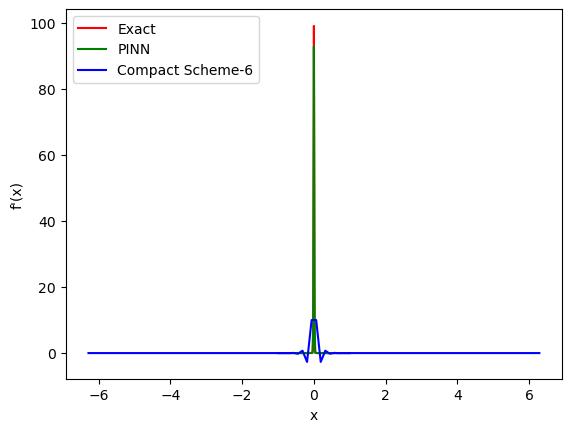

In [17]:
# Plot
fig, ax1 = plt.subplots()
x1=torch.linspace(min,max,10*total_points)
# ax1.plot(x,y_plot,color='blue',label='Real')
# ax1.plot(x,yh_plot,color='red',label='Predicted')
ax1.plot(x1,PDE(x1),color='red',label='Exact')
ax1.plot(x,f_x_plot,color='green',label='PINN')
ax1.plot(com[:,0],com[:,1],color='blue',label='Compact Scheme-6')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel("f'(x)",color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

In [18]:
y=f_BC(x)
y=y.cpu().detach().numpy()

In [19]:
np.max(f_x_plot)

92.74038

In [20]:
y=f_BC(x)
y=y.cpu().detach().numpy()
dy=y.copy()
dx=x[1]-x[0]
nx=len(x)
for i in range(1, nx):
    dy[i] = (y[i] - y[i - 1])/dx

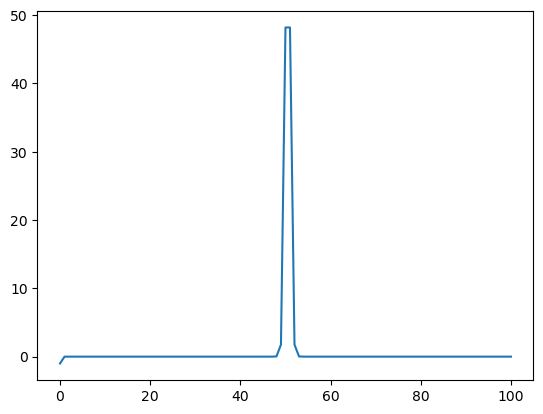

In [21]:
plt.plot(dy)

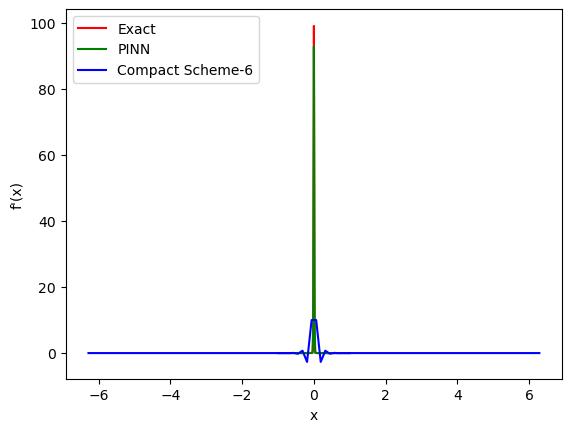

In [22]:
# Plot
fig, ax1 = plt.subplots()
x1=torch.linspace(min,max,10*total_points)
# ax1.plot(x,y_plot,color='blue',label='Real')
# ax1.plot(x,yh_plot,color='red',label='Predicted')
ax1.plot(x1,PDE(x1),color='red',label='Exact')
ax1.plot(x,f_x_plot,color='green',label='PINN')
ax1.plot(com[:,0],com[:,1],color='blue',label='Compact Scheme-6')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel("f'(x)",color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

In [23]:
d_bs=np.hstack([x,dy])
d_pinn=np.hstack([x,f_x_plot])

In [24]:
np.savetxt('d_bs_df.dat',d_bs)
np.savetxt('d_pinn_df.dat',d_pinn)

In [25]:
yex=PDE(x1)
yex_p=torch.vstack([x1,yex])
yex_p.shape
yex_p1=yex_p.cpu().detach().numpy()

In [26]:
yex_p1=np.transpose(yex_p1)


In [27]:
np.savetxt('d_ex_df.dat',yex_p1)